<a href="https://www.kaggle.com/code/saipraveenreddyallam/basic-model-gbdt-rf-xgb-lgbm?scriptVersionId=151887104" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Importing Libraries

In [74]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, GridSearchCV)

from sklearn.linear_model import LinearRegression
# from sklego.linear_model import LADRegression
from sklearn.ensemble import (GradientBoostingRegressor, RandomForestRegressor)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import statsmodels.api as sm
from statsmodels.stats.diagnostic import (linear_rainbow, het_white)
from scipy.stats import shapiro

from sklearn.metrics import (r2_score, median_absolute_error)
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

### Reading Data & basic info regrading the data

In [75]:
org_data = pd.read_csv("/kaggle/input/prediction-of-mohs-hardness-with-machine-learning/jm79zfps6b-1/Mineral_Dataset_Supplementary_Info.csv", index_col = "Unnamed: 0")
df_train = pd.read_csv("/kaggle/input/playground-series-s3e25/train.csv", index_col = "id")
df_test = pd.read_csv("/kaggle/input/playground-series-s3e25/test.csv", index_col = "id")

In [76]:
df_train.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
id,,,,,,,,,,,,
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [77]:
display(df_train.columns)
display(org_data.columns)
display(df_test.columns)

Index(['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average', 'Hardness'],
      dtype='object')

Index(['Hardness', 'allelectrons_Total', 'density_Total',
       'allelectrons_Average', 'val_e_Average', 'atomicweight_Average',
       'ionenergy_Average', 'el_neg_chi_Average', 'R_vdw_element_Average',
       'R_cov_element_Average', 'zaratio_Average', 'density_Average'],
      dtype='object')

Index(['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average'],
      dtype='object')

In [78]:
def basic_info(df, label):
    print(f"for {label} data : \n{'-'*50}")
    print(f"# of records = {df.shape[0]}\n# of features = {df.shape[1]}")
    print(f"missing values = {df.isna().sum().sum()}")
    print(f"duplicated records = {df.duplicated().sum()}\n")

In [79]:
basic_info(df_train, "train")
basic_info(org_data, "original")
basic_info(df_test, "test")

for train data : 
--------------------------------------------------
# of records = 10407
# of features = 12
missing values = 0
duplicated records = 0

for original data : 
--------------------------------------------------
# of records = 622
# of features = 12
missing values = 0
duplicated records = 23

for test data : 
--------------------------------------------------
# of records = 6939
# of features = 11
missing values = 0
duplicated records = 0



In [80]:
df_train.dtypes.reset_index()

,index,0
0,allelectrons_Total,float64
1,density_Total,float64
2,allelectrons_Average,float64
3,val_e_Average,float64
4,atomicweight_Average,float64
5,ionenergy_Average,float64
6,el_neg_chi_Average,float64
7,R_vdw_element_Average,float64
8,R_cov_element_Average,float64
9,zaratio_Average,float64


In [81]:
display("statistical info of training data : ", df_train.describe().T)
display("statistical info of original data : ", org_data.describe().T)
display("statistical info of testing data : ", df_test.describe().T)

'statistical info of training data : '

,count,mean,std,min,25%,50%,75%,max
allelectrons_Total,10407.0,128.053516,224.123776,0.0,68.000000,100.000000,131.000000,15300.000000
density_Total,10407.0,14.491342,15.972877,0.0,7.558488,10.650000,16.676996,643.093804
allelectrons_Average,10407.0,17.033222,10.468734,0.0,10.000000,12.600000,22.000000,67.000000
val_e_Average,10407.0,4.546789,0.690864,0.0,4.000000,4.714286,4.800000,6.000000
atomicweight_Average,10407.0,37.507703,26.012313,0.0,20.298893,26.203827,48.719500,167.400000
ionenergy_Average,10407.0,10.938308,1.408276,0.0,10.590660,11.202760,11.670725,15.245810
el_neg_chi_Average,10407.0,2.607662,0.334906,0.0,2.530000,2.706000,2.805000,3.443000
R_vdw_element_Average,10407.0,1.731330,0.192481,0.0,1.672500,1.732727,1.800000,2.250000
R_cov_element_Average,10407.0,0.944132,0.180017,0.0,0.864000,0.915556,0.981667,1.615840
zaratio_Average,10407.0,0.493349,0.063080,0.0,0.476196,0.488550,0.496070,0.825990


'statistical info of original data : '

,count,mean,std,min,25%,50%,75%,max
Hardness,622.0,4.613987,1.729636,1.0,3.000000,5.500000,5.950000,10.000000
allelectrons_Total,622.0,312.895691,853.331650,0.0,98.250000,186.500000,390.000000,15300.000000
density_Total,622.0,27.864836,39.243940,0.0,10.561656,20.744196,34.824490,643.093804
allelectrons_Average,622.0,14.808027,9.963898,0.0,9.371995,10.852814,17.416667,67.000000
val_e_Average,622.0,4.419379,0.807960,0.0,4.058333,4.636364,4.800000,6.000000
atomicweight_Average,622.0,32.243577,24.586056,0.0,18.833820,22.197615,38.852958,167.400000
ionenergy_Average,622.0,11.108756,1.748614,0.0,10.961967,11.359643,11.804828,14.163933
el_neg_chi_Average,622.0,2.626550,0.402856,0.0,2.629196,2.708831,2.774951,3.426381
R_vdw_element_Average,622.0,1.670637,0.256487,0.0,1.612857,1.713333,1.763561,2.250000
R_cov_element_Average,622.0,0.875162,0.197932,0.0,0.796770,0.887321,0.949722,1.500000


'statistical info of testing data : '

,count,mean,std,min,25%,50%,75%,max
allelectrons_Total,6939.0,126.460128,207.564499,0.0,68.000000,100.000000,128.000000,10116.000000
density_Total,6939.0,14.794020,18.982447,0.0,7.558488,10.650000,16.601328,643.093804
allelectrons_Average,6939.0,17.406186,10.996089,0.0,10.000000,12.666667,22.000000,67.000000
val_e_Average,6939.0,4.546852,0.683158,0.0,4.000000,4.750000,4.800000,6.000000
atomicweight_Average,6939.0,38.422790,27.344351,0.0,20.298893,26.203827,48.719500,167.400000
ionenergy_Average,6939.0,10.921512,1.378980,0.0,10.584314,11.202760,11.645560,15.245810
el_neg_chi_Average,6939.0,2.608119,0.322873,0.0,2.527500,2.706000,2.806667,3.443000
R_vdw_element_Average,6939.0,1.737907,0.190584,0.0,1.678000,1.736000,1.820000,2.250000
R_cov_element_Average,6939.0,0.949638,0.179266,0.0,0.866667,0.920000,0.990000,1.615333
zaratio_Average,6939.0,0.491675,0.060829,0.0,0.476095,0.488550,0.496118,0.825990


1. no duplicated records present in the dataset, except in org_data
2. Data shape
    - Training data
        -  10407 rows and 11 columns
    - Org data
        - 622 rows and 12 columns
    - Test data
        - 6939 rows and 11 columns
3. no categorical features in the given dataset
3. no missing values in the dataset

- there might some outliers in
    - **allelectrons_Total**,
    - **density_total**,
    - **allelectrons_Average**,
    - **atomicweight_Average**,
    - **density_Average**

In [82]:
df = pd.concat([df_train, org_data]).drop_duplicates()
df.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


### EDA

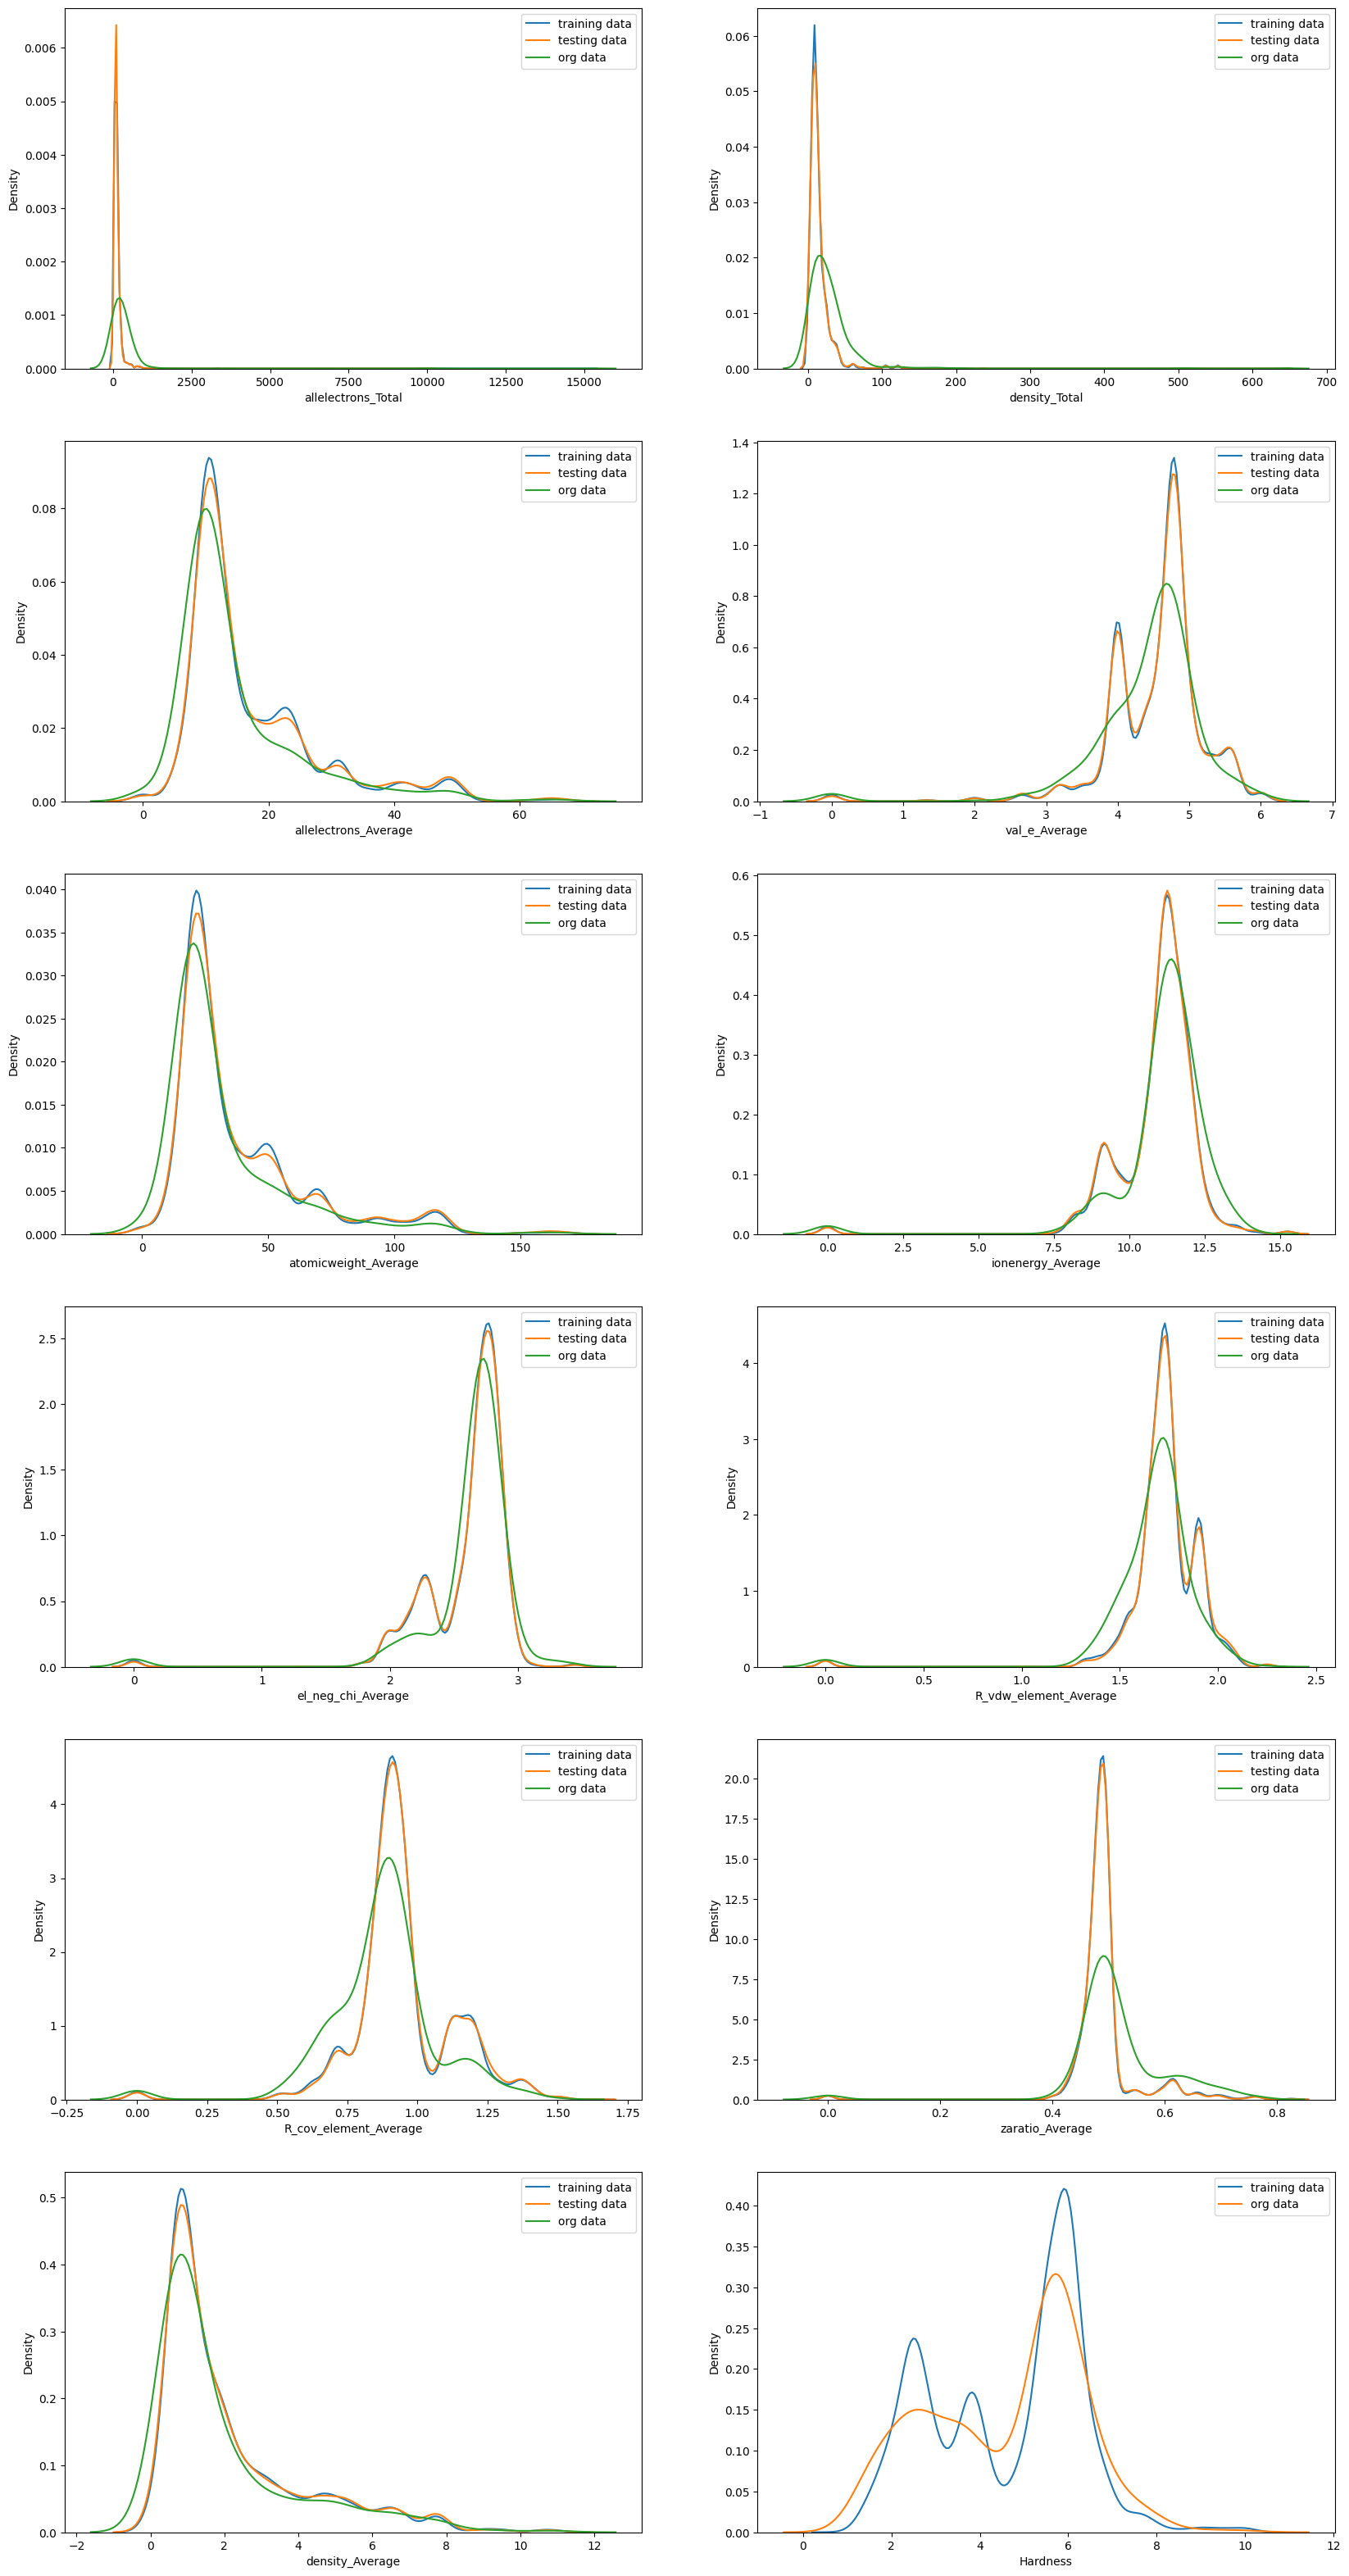

In [83]:
plt.figure(figsize = (20,40))
rows, cols = df_train.shape[1]//2, 2
ind = 1

for col in df_train.columns:
    if col != "Hardness":
        plt.subplot(rows, cols, ind)
        sns.kdeplot(x = df_train[col], label = "training data")
        sns.kdeplot(x = df_test[col], label = "testing data")
        sns.kdeplot(x = org_data[col], label = "org data")
        plt.legend()
    else:
        plt.subplot(rows, cols, ind)
        sns.kdeplot(x = df_train[col], label = "training data")
        sns.kdeplot(x = org_data[col], label = "org data")
        plt.legend()
    ind += 1
    
plt.show()    


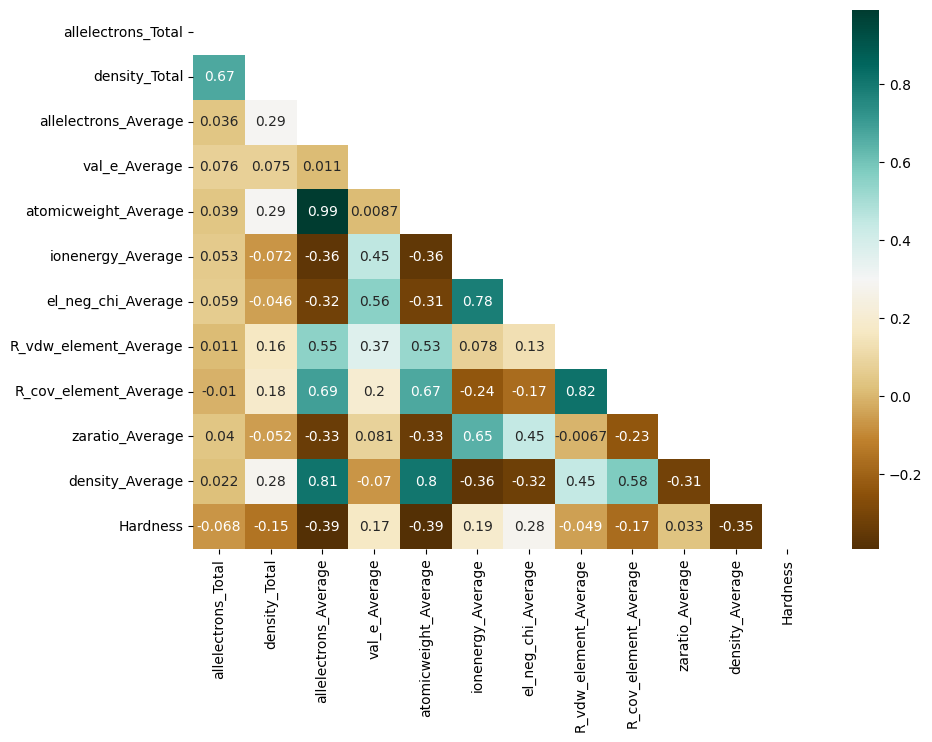

In [84]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df.corr(), annot = True,  cmap = 'BrBG', ax = ax, mask = np.triu(np.ones_like(df.corr(), dtype=bool)))
plt.show()

- the training data and test data almost follows the same distribution
- but the distribution of org data is different when compared
- **allelectons_Total**, **density_Totals**, **allelectrons_Average**, **atomicweight_Average** and **density_Average** are right skewed and heavy tails
- **val_e_Average**, **ionenergy_Average**, **el_neg_chi_Average**, **R_vdw_element_Average** and **R_cov_element_Average** are left skewed and heavy tails
- **atomicweight_Average**, **allelectrons_Average** are heavily corelated

### Data Preprocesing

In [85]:
df.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [86]:
def corr_features(df):    
    df["atomicweight_Average"] = (df["atomicweight_Average"] + df["allelectrons_Average"])/2
    df.drop("allelectrons_Average", axis = 1, inplace = True)
    return df

In [87]:
df = corr_features(df)

In [88]:
skewness = df.skew()

global right_skewed, left_skewed
right_skewed = []
left_skewed = []
for feature, skew_value in skewness.items():
    if skew_value > 0.5:
        right_skewed.append(feature)
    elif skew_value < -0.5:
        left_skewed.append(feature)

In [89]:
def feature_normalisation(df, rskew = right_skewed, lskew = left_skewed):
    for col in rskew:
        df[col] = np.log1p(df[col])
    for col in lskew:
        df[col] = df[col]**.5 
    return df       


In [90]:
df = feature_normalisation(df)

### Model

In [91]:
scores = {}

In [92]:
X = df.drop("Hardness", axis = 1).copy()
y = df.Hardness.copy()

In [93]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11)

print(f"Training data info : ")
print(f"    1. x_train shape = {x_train.shape}\n    2. y_train shape = {y_train.shape}\n")
print(f"Testing data info : ")
print(f"    1. x_test shape = {x_test.shape}\n    2. y_test shape = {y_test.shape}")

Training data info : 
    1. x_train shape = (8804, 10)
    2. y_train shape = (8804,)

Testing data info : 
    1. x_test shape = (2202, 10)
    2. y_test shape = (2202,)


In [94]:
def train_test_score(y_train, y_test, y_pred_train, y_pred_test):
    print(f"training score = {median_absolute_error(y_train, y_pred_train)}")
    print(f"testing score = {median_absolute_error(y_test, y_pred_test)}")
    return median_absolute_error(y_train, y_pred_train), median_absolute_error(y_test, y_pred_test)

#### Linear Regression

In [95]:
scaler = StandardScaler()
scaler.fit(x_train)

x_train_sca = scaler.transform(x_train)
x_test_sca = scaler.transform(x_test)

In [96]:
linear_model = LinearRegression(n_jobs = -1)
linear_model.fit(x_train_sca, y_train)

LinearRegression(n_jobs=-1)

In [97]:
train_score, test_score = train_test_score(y_train, y_test, linear_model.predict(x_train_sca), linear_model.predict(x_test_sca))
scores["linear_model"] = {"train_score" : train_score, "test_score" : test_score}

training score = 1.0537254820580721
testing score = 1.0543483024927967


##### linear regression assumptions

1. Linearity

    - The relationship between dependent and independent variables should be linear

In [98]:
x_sm = sm.add_constant(x_train_sca)
stat_model = sm.OLS(y_train, x_sm).fit()

rainbow_statistic, rainbow_p_value = linear_rainbow(stat_model)

if rainbow_p_value > 0.05:
    print('There is no evidence of nonlinearity in the model.')
else:
    print('There may be evidence of nonlinearity in the model')

There is no evidence of nonlinearity in the model.


2. No Multicolieanrity

    - there should be no coorelation between two features

In [99]:
def calc_vif(X):
    # Calculating the VIF
    vif=pd.DataFrame()
    vif['Feature']=X.columns
    vif['VIF']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif['VIF']=round(vif['VIF'],2)
    vif=vif.sort_values(by='VIF',ascending=False)
    return vif

calc_vif(X)

# there is high multicolinearity

,Feature,VIF
6,R_vdw_element_Average,730.81
4,ionenergy_Average,629.38
5,el_neg_chi_Average,494.01
7,R_cov_element_Average,377.43
8,zaratio_Average,294.52
2,val_e_Average,257.54
3,atomicweight_Average,178.84
0,allelectrons_Total,110.99
1,density_Total,43.44
9,density_Average,17.05


3. Errors are normally distributed

    - the residuals/ errors follow a normal distribution

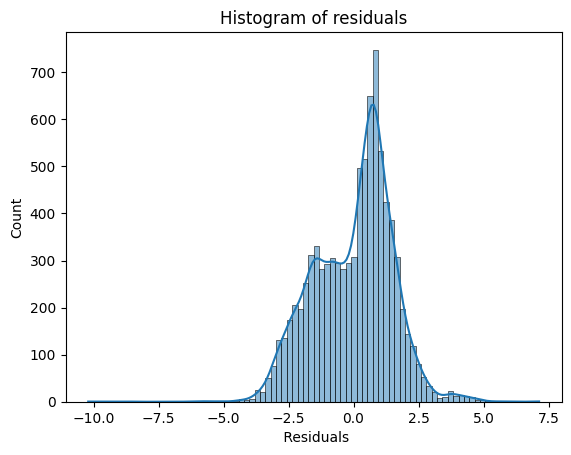

p value of the Shapiro-Wilk test: 3.5108754262238196e-32
The residuals do not follow a normal distribution


In [100]:
residuals = y_train - linear_model.predict(x_train_sca)
sns.histplot(residuals, kde = True)
plt.xlabel(" Residuals")
plt.title("Histogram of residuals")
plt.show()

test_stat, p_value = shapiro(residuals)
print(f'p value of the Shapiro-Wilk test: {p_value}')

if p_value > 0.05:
    print('The residuals follow a normal distribution.')
else:
    print('The residuals do not follow a normal distribution')

4. No Heteroskedasticity

    - the presence of non-constant variance in the error terms results in heteroskedasticity

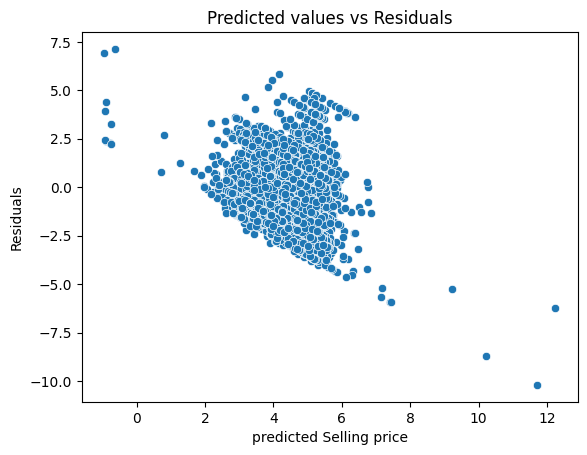

In [101]:
sns.scatterplot(x=linear_model.predict(x_train_sca),y=residuals)
plt.xlabel("predicted Selling price")
plt.ylabel("Residuals")
plt.title("Predicted values vs Residuals")
plt.show()

In [102]:
_, p_value, _, _ = het_white(stat_model.resid, x_sm)

if p_value > 0.05:
    print(f"There is no significant evidence of heteroskedasticity")
else:
    print(f"There is significant evidence of heteroskedasticity")

# we can use het_breuschpagan also

There is significant evidence of heteroskedasticity


#### RandomForest Regressor

In [103]:
# grid = {
#     'n_estimators': [val for val in range (100,1001, 100)],
#     'max_features': ['sqrt','log2'],
#     'max_depth' : [val for val in range (3,11)],
#     'random_state' : [18],
#     'n_jobs' : [-1]
# }

# cv_rfr = RandomizedSearchCV(RandomForestRegressor(), grid, n_jobs = -1)
# cv_rfr.fit(x_train, y_train)

# {'random_state': 18,
#  'n_jobs': -1,
#  'n_estimators': 800,
#  'max_features': 'log2',
#  'max_depth': 10}

In [104]:
rfr_model = RandomForestRegressor(n_estimators=800, max_features="log2", max_depth=10, n_jobs=-1, random_state=11).fit(x_train, y_train)

In [105]:
train_score, test_score = train_test_score(y_train, y_test, rfr_model.predict(x_train), rfr_model.predict(x_test))
scores["rfr_model"] = {"train_score" : train_score, "test_score" : test_score}

training score = 0.5545582057593101
testing score = 0.6604837103032468


#### GradientBoosting Regression

In [106]:
# param_distributions = {
#     'n_estimators': [val for val in range (100,1001, 100)],
#     'max_features': ['sqrt','log2'],
#     'max_depth' : [val for val in range (3,11)],
#     "min_samples_split" : [val for val in range(1,10,1)],
#     "min_samples_leaf" : [val for val in range(1,10,1)],
#     "max_depth" : [val for val in range(1,10,1)]
# }
# cv_gbr = RandomizedSearchCV(
#     GradientBoostingRegressor(),
#     param_distributions=param_distributions,
#     scoring="neg_mean_absolute_error",
#     n_jobs=-1
# )
# cv_gbr.fit(x_train, y_train)

# {'n_estimators': 600,
#  'min_samples_split': 9,
#  'min_samples_leaf': 6,
#  'max_features': 'sqrt',
#  'max_depth': 3}

In [107]:
gbr_model = GradientBoostingRegressor(n_estimators=600,min_samples_split=9, min_samples_leaf=6, max_features="sqrt", max_depth=3).fit(x_train, y_train)

train_score, test_score = train_test_score(y_train, y_test, gbr_model.predict(x_train), gbr_model.predict(x_test))
scores["gbr_model"] = {"train_score" : train_score, "test_score" : test_score}

training score = 0.5613225908279063
testing score = 0.666295333591861


#### XGBoostRegressor

In [108]:
xgbr_model = XGBRegressor()
xgbr_model.fit(x_train, y_train)                          

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [109]:
train_score, test_score = train_test_score(y_train, y_test, xgbr_model.predict(x_train), xgbr_model.predict(x_test))
scores["xgbr_model"] = {"train_score" : train_score, "test_score" : test_score}

training score = 0.323169469833374
testing score = 0.678869867324829


#### LGBMRegressor

In [110]:
lbgmr_model = LGBMRegressor()
lbgmr_model.fit(x_train, y_train)

LGBMRegressor()

In [111]:
train_score, test_score = train_test_score(y_train, y_test, lbgmr_model.predict(x_train), lbgmr_model.predict(x_test))
scores["lbgmr_model"] = {"train_score" : train_score, "test_score" : test_score}

training score = 0.5246844213809818
testing score = 0.6311201069413945


In [112]:
score = pd.DataFrame(scores).T.sort_values(by = "test_score", ascending = True)
score

,train_score,test_score
lbgmr_model,0.524684,0.631120
rfr_model,0.554558,0.660484
gbr_model,0.561323,0.666295
xgbr_model,0.323169,0.678870
linear_model,1.053725,1.054348


#### LinearRegression on top RandomForestRegression, LGBMRegressor

In [113]:
X = np.column_stack((rfr_model.predict(x_train), lbgmr_model.predict(x_train)))
model = LinearRegression().fit(pd.DataFrame(X).set_index(x_train.index), y_train)

In [114]:
test_b = np.column_stack((rfr_model.predict(x_test), lbgmr_model.predict(x_test)))

In [115]:
train_score, test_score = train_test_score(y_train, y_test, model.predict(pd.DataFrame(X).set_index(x_train.index)), model.predict(test_b))

training score = 0.47578545991020915
testing score = 0.5791320298262423


### Train Model

In [116]:
df_test = corr_features(df_test)
df_test = feature_normalisation(df_test)

pred = np.column_stack((rfr_model.predict(df_test), lbgmr_model.predict(df_test)))
pred = model.predict(pred)

In [117]:
res = pd.read_csv('/kaggle/input/playground-series-s3e25/sample_submission.csv')
res["Hardness"] = pred

In [118]:
res.to_csv('submission.csv', index=False)